###**imports**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import sys
from collections import Counter, OrderedDict
import itertools
from itertools import islice, count, groupby
import pandas as pd
import os
import re
from operator import itemgetter
import nltk
from nltk.stem.porter import *
from nltk.corpus import stopwords
from time import time
from timeit import timeit
from pathlib import Path
import pickle
import pandas as pd
import numpy as np
nltk.download('stopwords')

!pip install -q pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
!pip install -q graphframes

Mounted at /content/drive


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 10.2 MB/s eta 0:00:00
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  openjdk-8-jre-headless
Suggested packages:
  openjdk-8-demo openjdk-8-source libnss-mdns fonts-dejavu-extra
  fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  openjdk-8-jdk-headless openjdk-8-jre-headless
0 upgraded, 2 newly installed, 0 to remove and 21 not upgraded.
Need to get 36.6 MB of archives.
After this operation, 143 MB of additional disk space will be used.
Selecting previously unselected package openjdk-8-jre-headless:amd64.
(Reading database ... 124016 files and directories currently installed.)
Pre

###**load from drive**

In [2]:
import pickle
DL_text = '/content/drive/MyDrive/Proj_IR_23/DL_text.pkl'
with open(DL_text, 'rb') as f:
    DL_text = pickle.load(f)

DL_title = '/content/drive/MyDrive/Proj_IR_23/DL_title.pkl'
with open(DL_title, 'rb') as f:
    DL_title = pickle.load(f)

title_id  = '/content/drive/MyDrive/Proj_IR_23/title_id.pkl'
with open(title_id, 'rb') as f:
    title_id = pickle.load(f)

page_rank  = '/content/drive/MyDrive/Proj_IR_23/pagerank/pagerank.pkl'
with open(page_rank, 'rb') as f:
    page_rank = pickle.load(f)

page_views  = '/content/drive/MyDrive/Proj_IR_23/pageviews/pageviews-202108-user.pkl'
with open(page_views, 'rb') as f:
    page_views = pickle.load(f)


In [3]:
!cp -r /content/drive/MyDrive/Proj_IR_23/inverted_index_colab.py /content/

!cp -r /content/drive/MyDrive/Proj_IR_23/inverted_index_gcp.py /content/
from inverted_index_colab import *
from inverted_index_gcp import *


In [4]:
file_name_title = '/content/drive/MyDrive/Proj_IR_23/title_pos/'
file_name_body = '/content/drive/MyDrive/Proj_IR_23/body_pos/'
file_name_anchor = '/content/drive/MyDrive/Proj_IR_23/ANCOR_pos/'

In [5]:
title_index = InvertedIndex.read_index(file_name_title,'title_index')
body_index=InvertedIndex.read_index(file_name_body, 'body_index')
anchor_index=InvertedIndex.read_index(file_name_anchor, 'anchor_index')

###**tokenize**

In [6]:

RE_WORD = re.compile(r"""[\#\@\w](['\-]?\w){2,24}""", re.UNICODE)
english_stopwords = frozenset(stopwords.words('english'))

corpus_stopwords = ["category", "references", "also", "external", "links",
                    "may", "first", "see", "history", "people", "one", "two",
                    "part", "thumb", "including", "second", "following",
                    "many", "however", "would", "became"]

all_stopwords = english_stopwords.union(corpus_stopwords)


def tokenize(text):
    """
    This function aims in tokenize a text into a list of tokens. Moreover, it filter stopwords.

    Parameters:
    -----------
    text: string , represting the text to tokenize.

    Returns:
    -----------
    list of tokens (e.g., list of tokens).
    """
    list_of_tokens = [token.group() for token in RE_WORD.finditer(text.lower()) if token.group() not in all_stopwords]
    return list_of_tokens


###**read posting list**

In [7]:
TUPLE_SIZE = 6       # We're going to pack the doc_id and tf values in this 
                     # many bytes.
TF_MASK = 2 ** 16 - 1 # Masking the 16 low bits of an integer

def read_posting_list(inverted, w,file_name):
  with closing(MultiFileReader()) as reader:
    locs = inverted.posting_locs[w]
    locs = [(file_name + lo[0], lo[1]) for lo in locs]
    b = reader.read(locs, inverted.df[w] * TUPLE_SIZE)
    posting_list = []
    for i in range(inverted.df[w]):
      doc_id = int.from_bytes(b[i*TUPLE_SIZE:i*TUPLE_SIZE+4], 'big')
      tf = int.from_bytes(b[i*TUPLE_SIZE+4:(i+1)*TUPLE_SIZE], 'big')
      posting_list.append((doc_id, tf))
    return posting_list

###**get candidate documents and scores**

In [8]:
import math
def get_candidate_documents_and_scores(query, index, file_name):
    """
    Generate a dictionary representing a pool of candidate documents for a given query. This function will go through every token in query_to_search
    and fetch the corresponding information (e.g., term frequency, document frequency, etc.') needed to calculate TF-IDF from the posting list.
    Then it will populate the dictionary 'candidates.'
    For calculation of IDF, use log with base 10.
    tf will be normalized based on the length of the document.
    Parameters:
    -----------
    query_to_search: list of tokens (str). This list will be preprocessed in advance (e.g., lower case, filtering stopwords, etc.').
                     Example: 'Hello, I love information retrival' --->  ['hello','love','information','retrieval']
    index:           inverted index loaded from the corresponding files.
    words,pls: iterator for working with posting.
    Returns:
    -----------
    dictionary of candidates. In the following format:
                                                               key: pair (doc_id,term)
                                                               value: tfidf score.
    """

    DL = DL_text
    words = list(index.term_total.keys())
    tokens = tokenize(query)
    query_counter = Counter(tokens)
    query_counterd = dict(query_counter)
    candidates = {}
    N = len(DL)
    for term in np.unique(tokens):

        if term in words:

            list_of_doc = read_posting_list(index, term, file_name)
            normlized_tfidf = []
            for doc_id, freq in list_of_doc:
                if (doc_id, freq) == (0, 0):
                    continue

                formula = (freq / DL[doc_id]) * math.log(N / index.df[term], 10) * query_counterd[term]
                id_tfidf = (doc_id, formula)
                normlized_tfidf.append(id_tfidf)

            for doc_id, tfidf in normlized_tfidf:
                candidates[(doc_id, term)] = candidates.get((doc_id, term), 0) + tfidf

    return candidates


###**search title**

In [9]:
def search_title_our(query, index_title, file_name):
    query_to = tokenize(query)
    query_counter = Counter(query_to)
    title_dic = {}
    doc_lists = []
    # print(query_counter.keys())
    for token in query_counter.keys():
        try:
            # print(token)
            posting = read_posting_list(index_title, token, file_name)
            # print(posting)
            for doc_id, frequency in posting:
                if doc_id not in title_dic:
                    title_dic[doc_id] = 0
                title_dic[doc_id] += 1
        except:
            pass
    #print(sorted(title_dic.items(), key=lambda x: x[1], reverse=True))
    for i in sorted(title_dic.items(), key=lambda x: x[1], reverse=True):
        try:
            i = i[0]
            # print(i)
            title = title_id[i]
            doc_lists.append((i, title))

        except:
            pass

    return doc_lists

###**search BM25 for some index**

In [10]:
import math



def Search_BM25_for_some_index(queries, index , file_name):#(queries,N=5):
    if index == title_index:
      DL = DL_title
      N = len(DL_title)
      AVGDL = sum(DL_title.values()) / N

    if index == body_index:
      DL = DL_text
      N = len(DL_text)
      AVGDL = sum(DL_text.values()) / N

    # size_corpus = 6348910   #size of the corpus
    # sum_sc = 2028630613    # sum of the length of all documents in the corpus
    # avg_doc_length_of_all_corpus = sum_sc / size_corpus
    tokens = tokenize(queries)
    relevant_docs = []
    term_docid_freq = {}
    k1 = 1.5 # k1 is a tuning parameter of BM25
    b = 0.75 # b is a tuning parameter of BM25
    term_docid_freq = {}
    all_docs_distinct = set()

    for term in tokens:
        if term in index.term_total:
            list_docid_tf_foreach_term = read_posting_list(index, term, file_name)
            for doc_id, freq in list_docid_tf_foreach_term:
                term_docid_freq[(term, doc_id)] = freq
                all_docs_distinct.add(doc_id)


    def BM25_score_docid_query(query, doc_id):

        idf = calc_idf(query)
        bm25 = 0
        for term in query:
            if (term, doc_id) in term_docid_freq:
                freq = term_docid_freq[(term, doc_id)]
                first = (k1 + 1) * freq
                secondpart = query[term] * idf[term]
                thirdpart = freq + k1 * (1 - b + b * (DL[doc_id] / AVGDL))
                bm25 += secondpart * (first / thirdpart)
        return bm25

    def calc_idf(query):
        idf = {}
        for term in query:
            if term in index.df.keys():
                term_in_doc = index.df[term]
                idf[term] = math.log(1 + (N - term_in_doc + 0.5) / (term_in_doc + 0.5)) 
            else:
                pass
        return idf


    doc_id_bm25 = [(doc_id, BM25_score_docid_query(dict(Counter(tokens)), doc_id)) for doc_id in all_docs_distinct] # 1.5,0.75
    doc_id_bm25=sorted(doc_id_bm25, key=lambda x: x[1], reverse=True)[:100] # take the top 100
    res = list({doc_id: title_id[doc_id] for doc_id, score in doc_id_bm25}.items()) # match doc_id to title

    return res

###**import train json**

In [11]:
import json
with open('new_train.json', 'rt') as f:
  queries = json.load(f)

###**cosine similarity**


In [12]:
def cosine_similarity(query, index,file_name):
    """
    Calculate the cosine similarity for each candidate document in D and a given query (e.g., Q).
    Generate a dictionary of cosine similarity scores 
    key: doc_id
    value: cosine similarity score
    
    Parameters:
    -----------
    D: DataFrame of tfidf scores.

    Q: vectorized query with tfidf scores
    
    Returns:
    -----------
    dictionary of cosine similarity score as follows:
                                                                key: document id (e.g., doc_id)
                                                                value: cosine similarty score.
    """
    #########################################################
    if index == body_index:
      DL = DL_text
    if index == title_index:
      DL = DL_title
    dict_cosine_sim={}
    candidates = get_candidate_documents_and_scores(query, index, file_name)
    for doc_id, tfidf in candidates.items():
          dict_cosine_sim[doc_id[0]] = tfidf / (len(query) * DL[doc_id[0]])
    
    return dict_cosine_sim

### **search body our**

In [13]:
def search_body_our(query, index, file_name):
  doc_lists = []
  body_dict =  cosine_similarity(query, index, file_name)
  for i in sorted(body_dict.items(), key=lambda x: x[1], reverse=True):
      try:
          i = i[0]
          title = title_id[i]
          doc_lists.append((i, title))
      except:
          pass
  return doc_lists[:100]

### **search body with score**

In [14]:
def search_body_our_with_score(query, index, file_name):
  doc_lists = []
  body_dict =  cosine_similarity(query, index, file_name)

  return sorted(body_dict.items(), key=lambda x: x[1], reverse=True)[:100]

### **search anchor our**

In [15]:
def search_anchor_our(query, index, file_name):
    query_to = tokenize(query)
    query_counter = Counter(query_to)
    words_counter = Counter()
    anchor_dic = {}
    doc_list_anchor = []
    for token in query_counter.keys():
        try:
            posting = read_posting_list(index, token, file_name)
       
            for doc_id, frequency in posting:
                if doc_id not in anchor_dic:
                    anchor_dic[doc_id] = 0
                anchor_dic[doc_id] += 1
        except:
            pass
    #print(sorted(anchor_dic.items(), key=lambda x: x[1], reverse=True))
    for i in sorted(anchor_dic.items(), key=lambda x: x[1], reverse=True):
        try:
            i = i[0]
            title = title_id[i]
            doc_list_anchor.append((i, title))
        except:
            pass
        
    return doc_list_anchor


###**get pagerank**

In [16]:
def get_pagerank():
  res = []
  for wiki_id in wiki_ids:
    value = 0
    try:
        value = page_rank[wiki_id]
    except Exception:
        pass
    res.append(value)
  return res

###**get pageviews**

In [17]:
def get_pageview():
  res = []
  for wiki_id in wiki_ids:
    value = 0
    try:
        value = page_views[wiki_id]
    except Exception:
        pass
    res.append(value)
  return res

### **search_BM25_title - if the len of query == 1 go to search title else go to Search_BM25_for_some_index**


In [18]:
def search_BM25_title(query):
  aa = tokenize(query) 
  if len(aa) ==1 :
    return search_title_our(query, title_index, file_name_title)
  else:
    return Search_BM25_for_some_index(query, body_index, file_name_body)

### **search_body_title_with_weight** - חיפוש השאילתא בפונקציית הכותרות ופונקציית החיפוש בנפרד ומיזוג התוצאות ע"י סדר חזרתם מהפונקציות

In [19]:
def search_body_title_with_weight(query): #   ,  title, body,title_weight, body_weight):
  
  title = search_title_our(query, title_index,  file_name_title)[:100]
  body = search_body_our(query, body_index,  file_name_body)
  #anchor = search_anchor_our(query, anchor_index,  file_name_anchor)

  # print(body)
  # # list1 = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0,7 ,0.8, 0.9]
  # # list2 = [0.9, 0.8, 0.7, 0]

  title_weight = 0.1
  body_weight = 0.9
  #anchor_weight = 0.1

  # Combine the scores from different search engines
  combined_results = {}
  count = 0
  for doc_id, title_score in title:
      
      combined_results[doc_id] = count * title_weight
      count += 1
    
  count = 0
  for doc_id, body_score in body:
      
      if doc_id in combined_results:
          combined_results[doc_id] += count * body_weight
      else:
          combined_results[doc_id] = count * body_weight
      count += 1
  # count = 0
  # for doc_id, anchor_score in anchor:
  #     count += 1
  #     if doc_id in combined_results:
  #         combined_results[doc_id] += count * anchor_weight
  #     else:
  #         combined_results[doc_id] = count * anchor_weight

  sorted_results = sorted(combined_results.items(), key=lambda x: x[1])[:100]

  return sorted_results

### **search_body_anchor_title_with_weight**  

In [20]:
def search_body_anchor_title_with_weight(query): #   ,  title, body,title_weight, body_weight):
  
  title = search_title_our(query, title_index,  file_name_title)[:200]
  body = search_body_our(query, body_index,  file_name_body)
  anchor = search_anchor_our(query, anchor_index,  file_name_anchor)

  title_weight = 0.1
  body_weight = 0.8
  anchor_weight = 0.1

  combined_results = {}
  count = 0
  for doc_id, title_score in title:
      
      combined_results[doc_id] = count * title_weight
      count += 1 
  count = 0
  for doc_id, body_score in body:
      if doc_id in combined_results:
          combined_results[doc_id] += count * body_weight
      else:
          combined_results[doc_id] = count * body_weight
      count += 1

  count = 0
  for doc_id, anchor_score in anchor:
      if doc_id in combined_results:
          combined_results[doc_id] += count * anchor_weight
      else:
          combined_results[doc_id] = count * anchor_weight
      count += 1

  sorted_results = sorted(combined_results.items(), key=lambda x: x[1])[:100]
  return sorted_results

###**search_body_title_one - if the len of query == 1 go to search title else go to earch_body_title_with_weight**

In [21]:
def search_body_title_one(query):
  aa = tokenize(query) 
  if len(aa) == 1:
    return search_title_our(query, title_index, file_name_title)
  else:
    return search_body_title_with_weight(query)

###**search_body_title_with_weight_BM25** bm25 חיפוש בעזרת 
 ומיזוג התוצאות


In [22]:
def search_body_title_with_weight_BM25(query): #   ,  title, body,title_weight, body_weight):
  
  title = Search_BM25_for_some_index(query, title_index,  file_name_title)[:200]
  body = Search_BM25_for_some_index(query, body_index,  file_name_body)
  #anchor = search_anchor_our(query, anchor_index,  file_name_anchor)

  title_weight = 0.1
  body_weight = 0.9
  #anchor_weight = 0.1

  # Combine the scores from different search engines
  combined_results = {}
  count = 0
  for doc_id, title_score in title:
      
      combined_results[doc_id] = count * title_weight
      count += 1
    
  count = 0
  for doc_id, body_score in body:
      if doc_id in combined_results:
          combined_results[doc_id] += count * body_weight
      else:
          combined_results[doc_id] = count * body_weight
      count += 1

  # count = 0
  # for doc_id, anchor_score in anchor:
  #     count += 1
  #     if doc_id in combined_results:
  #         combined_results[doc_id] += count * anchor_weight
  #     else:
  #         combined_results[doc_id] = count * anchor_weight

  sorted_results = sorted(combined_results.items(), key=lambda x: x[1])[:100]

  return sorted_results

###**search_query** - מחפש מילים נפוצות מתוך המסמכים שהוחזרו מפונקציית הכותרות ומפונקציית הטקסט וחיפוש מחדש בפונקציית הטקסט

In [23]:
def search_query(query):

  search_body1 = search_body_our(query, body_index, '/content/drive/MyDrive/Proj_IR_23/body_pos/' )[:50]
  search_title1 = search_title_our(query, title_index, '/content/drive/MyDrive/Proj_IR_23/title_pos/' )[:50]
  all_results = search_body1  + search_title1
  new_list = [x[1] for x in all_results]
  result_string = " ".join(new_list)
  result_string_token =tokenize(result_string)
  counter = Counter(result_string_token)
  most_common = counter.most_common(4)
  result_string = " ".join(i[0] for i in most_common) 
  search_body2 = Search_BM25(result_string)[:100]
  return search_body2

###**Search_BM25 - with random**

In [24]:

import math
import random
body_index.DL={}
body_index.DL = DL_text
def merge_lists(a, b):
    c = []
    b_first_elements = set(item[0] for item in b)
    for item in a:
        if item[0] in b_first_elements:
            c.append(item)
    return c
freq_AVG=[]   
freq_AVGG =[] 
def Search_BM25(queries):#(queries,N=5):
    size_corpus = 6348910
    sum_sc = 2028630613
    avg_doc_length_of_all_corpus= sum_sc/size_corpus
    tokens=tokenize(queries) #
    all_docs_distinct = []
    term_docid_freq = {}
    random_index = random.randint(0, len(tokens) - 1) # 0
    for term in tokens: ## best marvel movie
        if term in title_index.term_total and term in body_index.term_total and term==tokens[random_index]:
            rami_p = read_posting_list(title_index, term,'/content/drive/MyDrive/Proj_IR_23/title_pos/')
            lst_docid = []
            list_docid_tf_foreach_term = read_posting_list(body_index, term,'/content/drive/MyDrive/Proj_IR_23/body_pos/')

            for doc_id, freq in merge_lists(list_docid_tf_foreach_term,rami_p):
                term_docid_freq[(term, doc_id)] = freq*20
                freq_AVG.append(freq)
                lst_docid.append(doc_id)

            all_docs_distinct += lst_docid
        else:
            if term in body_index.term_total: # [best : 16000 , fdsfsdf]

                list_docid_tf_foreach_term = read_posting_list(body_index, term,'/content/drive/MyDrive/Proj_IR_23/body_pos/')

                lst_docid = []

                for doc_id, freq in list_docid_tf_foreach_term:
                    term_docid_freq[(term, doc_id)] = freq
                    freq_AVGG.append(freq)
                    lst_docid.append(doc_id)

                all_docs_distinct += lst_docid
    
    all_docs_distinct= set(all_docs_distinct)
    def BM25_score_docid_query(query, doc_id,k1=1.5, b=0.75):

        idf = calc_idf(query)
        bm25 = 0
        for term in query:
            if (term,doc_id) in term_docid_freq:
                freq=term_docid_freq[(term,doc_id)]
                first=(k1+1)* freq
                secondpart=query[term] * idf[term]
                thirdpart=freq + k1 * (1 - b + b * (body_index.DL[doc_id] / avg_doc_length_of_all_corpus))

                bm25 += secondpart * (first  / thirdpart) 
        return bm25



    def calc_idf(query):
        idf = {}
        for term in query:
            if term in body_index.df.keys():
                term_in_doc = body_index.df[term]
                idf[term] = math.log(1 + (size_corpus - term_in_doc + 0.5) / (term_in_doc + 0.5))
            else:
                pass
        return idf

    doc_id_bm25 = [(doc_id, BM25_score_docid_query(dict(Counter(tokens)), doc_id, 1.5, 0.75)) for doc_id in all_docs_distinct]
    

    doc_id_bm25=sorted(doc_id_bm25, key=lambda x: x[1], reverse=True)[:100]#[:N]
    #res = list({doc_id: title_id[doc_id] for doc_id, score in doc_id_bm25}.items())
    return doc_id_bm25


###**BM25 with condicion freq <= 50:**

In [25]:
def Search_BM25_with_condicion(queries):
    size_corpus = 6348910   #size of the corpus
    sum_sc = 2028630613    # sum of the length of all documents in the corpus
    avg_doc_length_of_all_corpus = sum_sc / size_corpus
    tokens = tokenize(queries)
    relevant_docs = []
    term_docid_freq = {}
    k1 = 1.5 # k1 is a tuning parameter of BM25
    b = 0.75 # b is a tuning parameter of BM25
    term_docid_freq = {}
    all_docs_distinct = set()

    for term in tokens:
        if term in body_index.term_total:
            list_docid_tf_foreach_term = read_posting_list(body_index, term,file_name_body)
            for doc_id, freq in list_docid_tf_foreach_term:
                if freq <= 50:
                  continue
                term_docid_freq[(term, doc_id)] = freq
                all_docs_distinct.add(doc_id)


    def BM25_score_docid_query(query, doc_id):

        idf = calc_idf(query)
        bm25 = 0
        for term in query:
            if (term, doc_id) in term_docid_freq:
                freq = term_docid_freq[(term, doc_id)]
                first = (k1 + 1) * freq
                secondpart = query[term] * idf[term]
                thirdpart = freq + k1 * (1 - b + b * (body_index.DL[doc_id] / avg_doc_length_of_all_corpus))
                bm25 += secondpart * (first / thirdpart)
        return bm25

    def calc_idf(query):
        idf = {}
        for term in query:
            if term in body_index.df.keys():
                term_in_doc = body_index.df[term]
                idf[term] = math.log(1 + (size_corpus - term_in_doc + 0.5) / (term_in_doc + 0.5)) 
            else:
                pass
        return idf


    doc_id_bm25 = [(doc_id, BM25_score_docid_query(dict(Counter(tokens)), doc_id)) for doc_id in all_docs_distinct] # 1.5,0.75
    doc_id_bm25=sorted(doc_id_bm25, key=lambda x: x[1], reverse=True)[:100] # take the top 100
    res = list({doc_id: title_id[doc_id] for doc_id, score in doc_id_bm25}.items()) # match doc_id to title

    return res

### **search_body_title_BM25_title - if the len of query == 1 go to search title else go to search_body_title_with_weigh_BM25**


In [26]:
def search_body_title_BM25_title(query):
  aa = tokenize(query) 
  if len(aa) == 1:
    return search_title_our(query, title_index, file_name_title)
  else:
    return search_body_title_with_weight_BM25(query)

### **search_body_title_BM25new_title - if the len of query == 1 go to search title else go to Search_bm25**

In [27]:
def search_body_title_BM25new_title(query):
  aa = tokenize(query) 
  if len(aa) == 1:
    return search_title_our(query, title_index, file_name_title)
  else:
    return Search_BM25(query)

###**the last 10 queries for testting**

In [28]:
items_list = list(queries.items())
last_10 = items_list[-10:]
last_10 = dict(last_10)


###**map@40**

In [29]:
def average_precision(true_list, predicted_list, k=40):
    true_set = frozenset(true_list)
    predicted_list = predicted_list[:k]
    precisions = []
    for i,doc_id in enumerate(predicted_list):        
        if doc_id in true_set:
            prec = (len(precisions)+1) / (i+1)            
            precisions.append(prec)
    if len(precisions) == 0:
        return 0.0
    return round(sum(precisions)/len(precisions),3)

In [30]:
functions = [search_body_our, search_title_our ,search_query, search_body_title_with_weight, search_body_anchor_title_with_weight, search_body_title_one, Search_BM25_for_some_index , search_body_title_with_weight_BM25, search_body_title_BM25_title, Search_BM25, Search_BM25_with_condicion]
qs_res = []
metrics = {func.__name__: {"q" : [] , "duration": [], "ap": [], 'pred wids': []} for func in functions}

count_query = 0
for q, true_wids in last_10.items():
    duration, ap = None, None

    #for func in functions:
    for func in functions:
        t_start = time()

        func_name = func.__name__
        if func.__name__ == "search_query":
            x = func(q)
        elif func.__name__ == "search_body_title_BM25_title":
            x = func(q)
        elif func.__name__ == "Search_BM25_with_condicion":
            x = func(q)
        elif func.__name__ == "search_body_our":
            x = func(q, body_index, file_name_body)
        elif func.__name__ == "search_title_our":
            x = func(q, title_index, file_name_title)
        elif func.__name__ == "Search_BM25_for_some_index":
            x = func(q, body_index, file_name_body)
        # elif func.__name__ == "search_anchor_our":
        #     x = func(q, anchor_index, file_name_anchor)
        elif func.__name__ == "search_body_title_one":
            x = func(q)
        elif func.__name__ == "search_with_bm_title":
            x = func(q)
        elif func.__name__ == "search_with_bm_title_new":
            x = func(q)
        elif func.__name__ == "search_body_title_with_weight":
            x = func(q)
        elif func.__name__ == "search_body_title_with_weight_BM25":
            x = func(q)
        elif func.__name__ == "search_body_title_BM25new_title":
            x = func(q)
        elif func.__name__ == "Search_BM25":
            x = func(q)
        elif func.__name__ == "search_body_anchor_title_with_weight":
            x = func(q)
        #x = func(q, body_index, file_name_body) 
        res = x[:100]
        duration = time() - t_start
        func = lambda x: x[0]
        pred_wids = [func(i) for i in res]
        ap = average_precision(true_wids, pred_wids)
        
        metrics[func_name]["q"].append(q)
        metrics[func_name]["duration"].append(duration)
        metrics[func_name]["ap"].append(ap)
        metrics[func_name]["pred wids"].append(pred_wids)

        # qs_res.append((q,func.__name__, duration, ap))
for func, values in metrics.items():
    print(f'Function: {func}')
    print(f'Average duration: {sum(values["duration"]) / len(values["duration"])}')
    print(f'Average AP: {sum(values["ap"]) / len(values["ap"])}')
    print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
# average_duration = sum(i[2] for i in qs_res) / len(qs_res)
# average_ap = sum(i[3] for i in qs_res) / len(qs_res)

# print("search :",func.__name__ )
# print("average duration:",average_duration)
# print("average ap:",average_ap)

Function: search_body_our
Average duration: 4.962886929512024
Average AP: 0.0
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Function: search_title_our
Average duration: 0.6137007951736451
Average AP: 0.4423
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Function: search_query
Average duration: 13.079551410675048
Average AP: 0.15619999999999998
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Function: search_body_title_with_weight
Average duration: 3.8634556770324706
Average AP: 0.3746
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Function: search_body_anchor_title_with_weight
Average duration: 5.377382779121399
Average AP: 0.2476
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Function: search_body_title_one
Average duration: 3.8667275667190553
Average AP: 0.38089999999999996
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Function: Search_BM25_for_some_index
Average duration: 4.582231950759888
Average AP: 0.46719999999999995
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Functio

In [57]:
Average_duration = []
Average_AP = []
for func, values in metrics.items():
    
    Average_duration.append(sum(values["duration"]) / len(values["duration"]))
    Average_AP.append(sum(values["ap"]) / len(values["ap"]))
print(Average_duration)
print(Average_AP)

[4.962886929512024, 0.6137007951736451, 13.079551410675048, 3.8634556770324706, 5.377382779121399, 3.8667275667190553, 4.582231950759888, 4.817967319488526, 4.57015643119812, 2.878605914115906, 0.618134331703186]
[0.0, 0.4423, 0.15619999999999998, 0.3746, 0.2476, 0.38089999999999996, 0.46719999999999995, 0.3131, 0.2992, 0.4558000000000001, 0.4889]


In [50]:
df = pd.DataFrame(metrics)

print(df.to_markdown())


|           | search_body_our                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

In [56]:
# aa = metrics['Search_BM25_with_condicion']["pred wids"][7][:10]
# #print(aa)
# for i in aa:
#   print(title_id[i])


Uma Canção para Ti (Portugal)
List of awards and nominations received by Armin van Buuren
UK Rock Challenge
List of Japanese adult video awards (1991–2008)
University of San Agustin Publications
List of American theatrical animated feature films (2000-2019)
List of The Best Show with Tom Scharpling episodes
List of albums titled Live
Toronto Rock 'n' Roll Revival 1969, Volume IV
List of The X Factor (British TV series) episodes


In [53]:
# print(df['Search_BM25_with_condicion'].q)
# print(df['Search_BM25_with_condicion'].ap)
# print(df['Search_BM25_with_condicion'].duration)

data = {'Topic': ['How to make hummus', 'Winter', 'Rick and Morty', 'Natural Language processing', 'World Cup 2022', 'Dolly the sheep', 'Cigarettes', 'What is the best place to live in?', 'Elon musk', 'How do you breed flowers?'],
        'Score': [1.0, 0.318, 0.818, 1.0, 0.0, 0.131, 0.643, 0.0, 0.887, 0.092]


        }
df = pd.DataFrame(data)
print(df.to_string(index=False))

                             Topic  Score
                How to make hummus  1.000
                            Winter  0.318
                    Rick and Morty  0.818
       Natural Language processing  1.000
                    World Cup 2022  0.000
                   Dolly the sheep  0.131
                        Cigarettes  0.643
What is the best place to live in?  0.000
                         Elon musk  0.887
         How do you breed flowers?  0.092


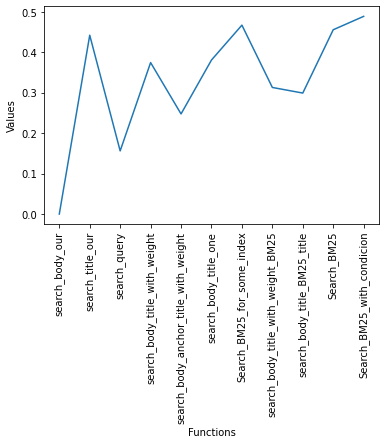

In [59]:
import matplotlib.pyplot as plt

functions = ['search_body_our', 'search_title_our' ,'search_query', 'search_body_title_with_weight', 'search_body_anchor_title_with_weight', 'search_body_title_one', 'Search_BM25_for_some_index' , 'search_body_title_with_weight_BM25', 'search_body_title_BM25_title', 'Search_BM25', 'Search_BM25_with_condicion']
values = [0.0, 0.4423, 0.15619999999999998, 0.3746, 0.2476, 0.38089999999999996, 0.46719999999999995, 0.3131, 0.2992, 0.4558000000000001, 0.4889]

  

plt.plot(functions, values)
plt.xlabel('Functions')
plt.ylabel('Values')
plt.xticks(rotation=90)
plt.show()








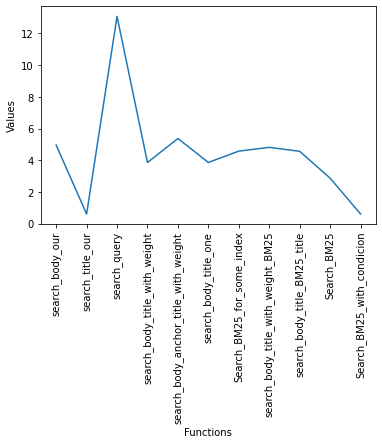

In [58]:

import matplotlib.pyplot as plt

functions = ['search_body_our', 'search_title_our' ,'search_query', 'search_body_title_with_weight', 'search_body_anchor_title_with_weight', 'search_body_title_one', 'Search_BM25_for_some_index' , 'search_body_title_with_weight_BM25', 'search_body_title_BM25_title', 'Search_BM25', 'Search_BM25_with_condicion']
values = [4.962886929512024, 0.6137007951736451, 13.079551410675048, 3.8634556770324706, 5.377382779121399, 3.8667275667190553, 4.582231950759888, 4.817967319488526, 4.57015643119812, 2.878605914115906, 0.618134331703186]


plt.plot(functions, values)
plt.xlabel('Functions')
plt.ylabel('Values')
plt.xticks(rotation=90)
plt.show()